In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch_geometric as tg
from torch_geometric.data import Data
from torch_geometric.utils import subgraph
from torch_geometric.nn import GAE, VGAE, GCNConv
from torch_geometric.utils.convert import from_networkx
import networkx as nx

In [3]:
import local2global_embedding.embedding.gae as gae
from local2global_embedding.network import TGraph

In [4]:
from dataloader import DataLoader
from models import speye, VGAEconv, GAEconv, VGAE_loss, GAE_loss, train

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device: ', device)

Device:  cuda


# Graph embeddings

To begin with, we consider three ways to embed the graph data: SVD, GAE and VGAE.

### Load and explore dataset

Before going into the patch graph, we explore embeddings of individual days using different methods.

In [6]:
date = '20000102'

In [7]:
dl = DataLoader(dataset='AS-733')
graph = dl.get_graph(date)
graph

array([[    1,     1,     1, ..., 65002, 65051, 65105],
       [  701,  2914,  2828, ...,  6509,  1668, 10994]])

In [8]:
# Create graph information in various formats that will be useful 
G=nx.from_edgelist(list(graph.transpose()))
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
edge_index = graph
tgraph = TGraph(edge_index)
node_list = np.unique(edge_index[0,:])

In [9]:
print('Number of nodes:' , num_nodes)
print('Number of edges:' , num_edges)
print('Number of trinagles:' , int(sum(nx.triangles(G).values())/3))
print('Number of self loops:', nx.number_of_selfloops(G))
if nx.is_connected(G):
    print('Is connected')

Number of nodes: 6474
Number of edges: 13895
Number of trinagles: 6584
Number of self loops: 1323
Is connected


### SVD Embedding

To be done. This is essentially PCA on the normalised adjacency matrix.

### GAE

In [10]:
test_data = Data(x=speye(dl.num_nodes), edge_index=torch.tensor(edge_index))
neg_edges = tg.utils.negative_sampling(test_data.edge_index, num_nodes=test_data.num_nodes)

In [11]:
model = GAE(encoder=GAEconv(2, test_data.num_node_features))

In [12]:
model = train(test_data, model, loss_fun=GAE_loss, num_epochs=200)

epoch 0: loss=1.3862941265106201
epoch 1: loss=1.379939079284668
epoch 2: loss=1.358974575996399
epoch 3: loss=1.3200597763061523
epoch 4: loss=1.2635209560394287
epoch 5: loss=1.1939619779586792
epoch 6: loss=1.1191871166229248
epoch 7: loss=1.0461993217468262
epoch 8: loss=0.9801418781280518
epoch 9: loss=0.9228682518005371
epoch 10: loss=0.874388575553894
epoch 11: loss=0.8344501256942749
epoch 12: loss=0.8004703521728516
epoch 13: loss=0.7748931646347046
epoch 14: loss=0.7537899613380432
epoch 15: loss=0.738021194934845
epoch 16: loss=0.7278551459312439
epoch 17: loss=0.721011757850647
epoch 18: loss=0.7203672528266907
epoch 19: loss=0.7198572158813477
epoch 20: loss=0.7126175165176392
epoch 21: loss=0.7243722081184387
epoch 22: loss=0.7201154828071594
epoch 23: loss=0.7236119508743286
epoch 24: loss=0.7247927784919739
epoch 25: loss=0.7268640398979187
epoch 26: loss=0.7343525886535645
epoch 27: loss=0.7349995374679565
epoch 28: loss=0.7388103008270264
epoch 29: loss=0.738129436969

In [15]:
with torch.no_grad():
    coord_ip = model.encode(test_data).numpy()

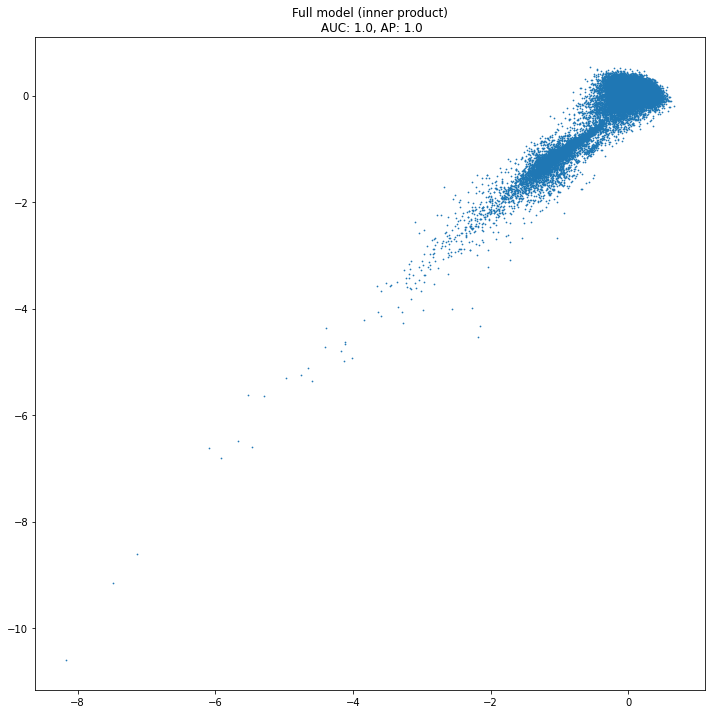

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(12,12))
ax.scatter(coord_ip[:, 0], coord_ip[:, 1], c=test_data.y, s=0.5)
auc, ap = model.test(torch.tensor(coord_ip), test_data.edge_index, neg_edges)
t = plt.title(f'Full model (inner product)\n AUC: {auc:.3}, AP: {ap:.3}')

In progress: embed induce subgraph (that is, without isolated nodes), use higher dimensions and visualise with UMAP, compute patches.

In [30]:
# Now only consider the induced subgraph on the present nodes, without the isolated nodes that are not present.
# There is probably a more elegant way of doing this.
nodes = np.unique(graph[0,:])
indices = list(range(len(nodes)))
nodedict = {nodes[i]: indices[i] for i in range(len(nodes))}
new_edges = np.array([[nodedict[e] for e in edge_index[0,:]], [nodedict[e] for e in edge_index[1,:]]])

In [34]:
test_data = Data(x=speye(new_edges.shape[1]), edge_index=torch.tensor(new_edges))
neg_edges = tg.utils.negative_sampling(test_data.edge_index, num_nodes=test_data.num_nodes)

In [35]:
model = GAE(encoder=GAEconv(2, test_data.num_node_features))

In [36]:
model = train(test_data, model, loss_fun=GAE_loss, num_epochs=200)

epoch 0: loss=1.3862922191619873
epoch 1: loss=1.3724238872528076
epoch 2: loss=1.337552547454834
epoch 3: loss=1.2779967784881592
epoch 4: loss=1.2015602588653564
epoch 5: loss=1.1166592836380005
epoch 6: loss=1.037654161453247
epoch 7: loss=0.969283401966095
epoch 8: loss=0.9141234159469604
epoch 9: loss=0.8723382353782654
epoch 10: loss=0.8389028906822205
epoch 11: loss=0.8124902248382568
epoch 12: loss=0.7932146787643433
epoch 13: loss=0.7744115591049194
epoch 14: loss=0.772144615650177
epoch 15: loss=0.7591065168380737
epoch 16: loss=0.7560656070709229
epoch 17: loss=0.760062038898468
epoch 18: loss=0.767966091632843
epoch 19: loss=0.7766128778457642
epoch 20: loss=0.7693799138069153
epoch 21: loss=0.7844741344451904
epoch 22: loss=0.7819855213165283
epoch 23: loss=0.7769778370857239
epoch 24: loss=0.7828418016433716
epoch 25: loss=0.7836483716964722
epoch 26: loss=0.7835959792137146
epoch 27: loss=0.7762975096702576
epoch 28: loss=0.7765638828277588
epoch 29: loss=0.7693592905998

In [37]:
with torch.no_grad():
    coord_ip = model.encode(test_data).numpy()

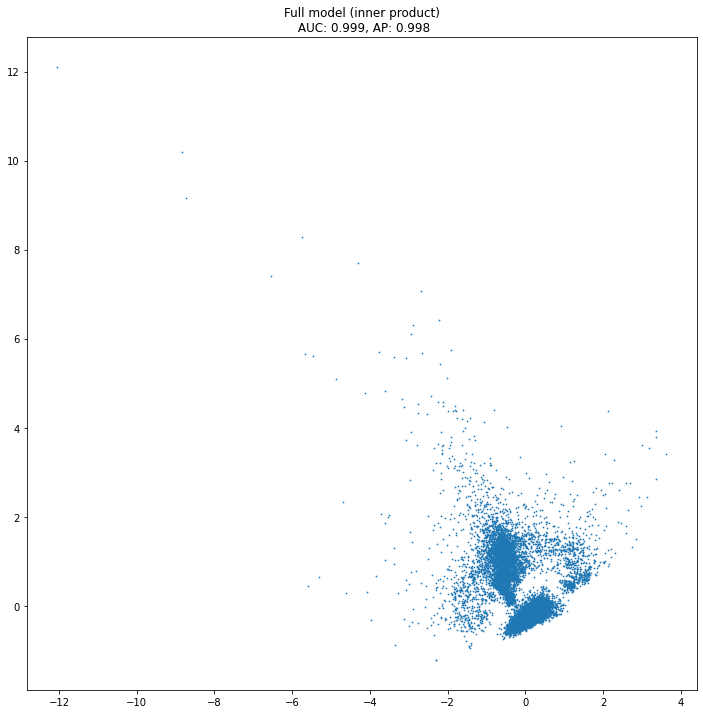

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(12,12))
ax.scatter(coord_ip[:, 0], coord_ip[:, 1], c=test_data.y, s=0.5)
auc, ap = model.test(torch.tensor(coord_ip), test_data.edge_index, neg_edges)
t = plt.title(f'Full model (inner product)\n AUC: {auc:.3}, AP: {ap:.3}')

### VGAE

In [39]:
model = VGAE(encoder=VGAEconv(2, test_data.num_node_features))

In [40]:
model = train(test_data, model, loss_fun=VGAE_loss, num_epochs=200)

epoch 0: loss=1.7592273950576782
epoch 1: loss=1.6992394924163818
epoch 2: loss=1.6075516939163208
epoch 3: loss=1.5476011037826538
epoch 4: loss=1.5343413352966309
epoch 5: loss=1.4911514520645142
epoch 6: loss=1.4790503978729248
epoch 7: loss=1.4533603191375732
epoch 8: loss=1.4420642852783203
epoch 9: loss=1.4265687465667725
epoch 10: loss=1.409548282623291
epoch 11: loss=1.3939608335494995
epoch 12: loss=1.3764922618865967
epoch 13: loss=1.3557875156402588
epoch 14: loss=1.3279234170913696
epoch 15: loss=1.2956901788711548
epoch 16: loss=1.2538959980010986
epoch 17: loss=1.217394232749939
epoch 18: loss=1.1678154468536377
epoch 19: loss=1.1192049980163574
epoch 20: loss=1.0939040184020996
epoch 21: loss=1.0628221035003662
epoch 22: loss=1.0405936241149902
epoch 23: loss=1.0106981992721558
epoch 24: loss=0.9773718118667603
epoch 25: loss=0.9453681707382202
epoch 26: loss=0.9096910953521729
epoch 27: loss=0.8800504207611084
epoch 28: loss=0.8598787188529968
epoch 29: loss=0.838282167

In [41]:
with torch.no_grad():
    coord_ip = model.encode(test_data).numpy()

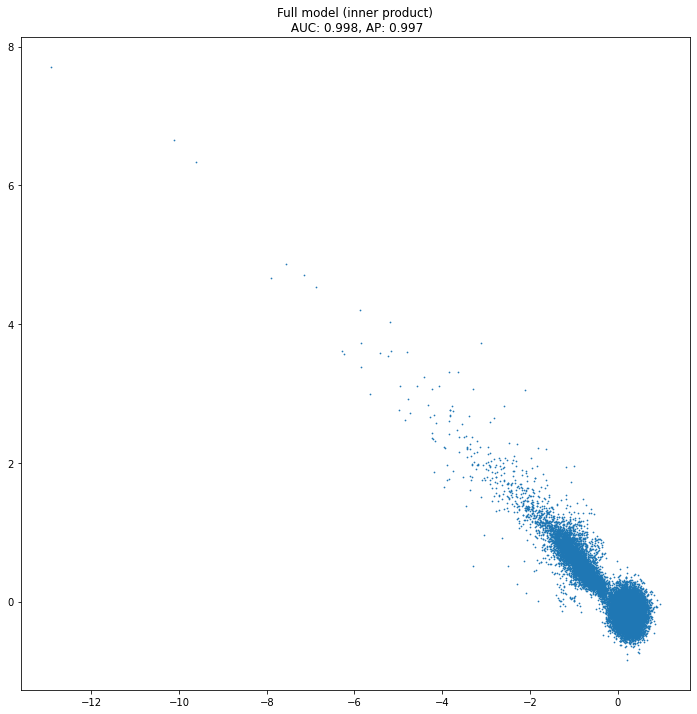

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(12,12))
ax.scatter(coord_ip[:, 0], coord_ip[:, 1], c=test_data.y, s=0.5)
auc, ap = model.test(torch.tensor(coord_ip), test_data.edge_index, neg_edges)
t = plt.title(f'Full model (inner product)\n AUC: {auc:.3}, AP: {ap:.3}')